In [2]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
import tree
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation
from omegaconf import OmegaConf
import importlib
import logging
import sys

from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from data import r3_diffuser
from data import digs_data_loader
from model import loss
from experiments import train_se3_diffusion

# Enable logging
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

Matplotlib created a temporary config/cache directory at /scratch/jyim/52774929/matplotlib-2tvqr49p because the default path (/home/jyim/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
INFO: Using numpy backend


In [3]:
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/home/jyim/Projects/protein_diffusion_v2/experiments/train_se3_diffusion.py'>

In [4]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'digs'

data_conf = conf.data
data_conf.digs.filtering.subset = 1
data_conf.digs.fraction_fb = 0.0

diff_conf = conf.diffuser
diff_conf.rot_schedule = 'logarithmic'
diff_conf.trans_schedule = 'linear'

In [5]:
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, train_sampler, valid_loader, valid_sampler = exp.create_digs_dataset(0, 1)
se3_diff = exp.diffuser
r3_diff = se3_diff._r3_diffuser
so3_diff = se3_diff._so3_diffuser

# Extract a protein backbone.
train_iter = iter(train_loader)
next_item = next(train_iter)
res_mask = next_item['res_mask'][0, :]
ca_pos = next_item['xyz'][0, :, 1, :][res_mask.bool()]

# SDE time parameters
num_t = 100
forward_t = np.linspace(1e-3, 1, num_t)
reverse_t = forward_t[::-1]
dt = 1 / num_t

INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl


# Translations

In [41]:
# Forward diffusion
x_0 = np.ones((1, 3))
marginal_samples = {}
for i,t in enumerate(forward_t):
    marginal_samples[i] = []
    for _ in range(500):
        marginal_samples[i].append(
            r3_diff.forward_marginal(x_0, t)[0]
        )

In [42]:
# Reverse diffusion
reverse_samples = {}
for _ in range(500):
    curr_step = r3_diff.sample_ref(n_samples=1)
    for i, t in reversed(list(enumerate(forward_t))):
        if i not in reverse_samples:
            reverse_samples[i] = []
        score_t = r3_diff.score(
            curr_step,
            x_0,
            t)
        curr_step = r3_diff.reverse(
            x_t=curr_step,
            score_t=score_t,
            t=t,
            dt=dt,
            center=False
        )
        reverse_samples[i].append(
            copy.deepcopy(curr_step)
        )

In [ ]:
reverse_samples[2]

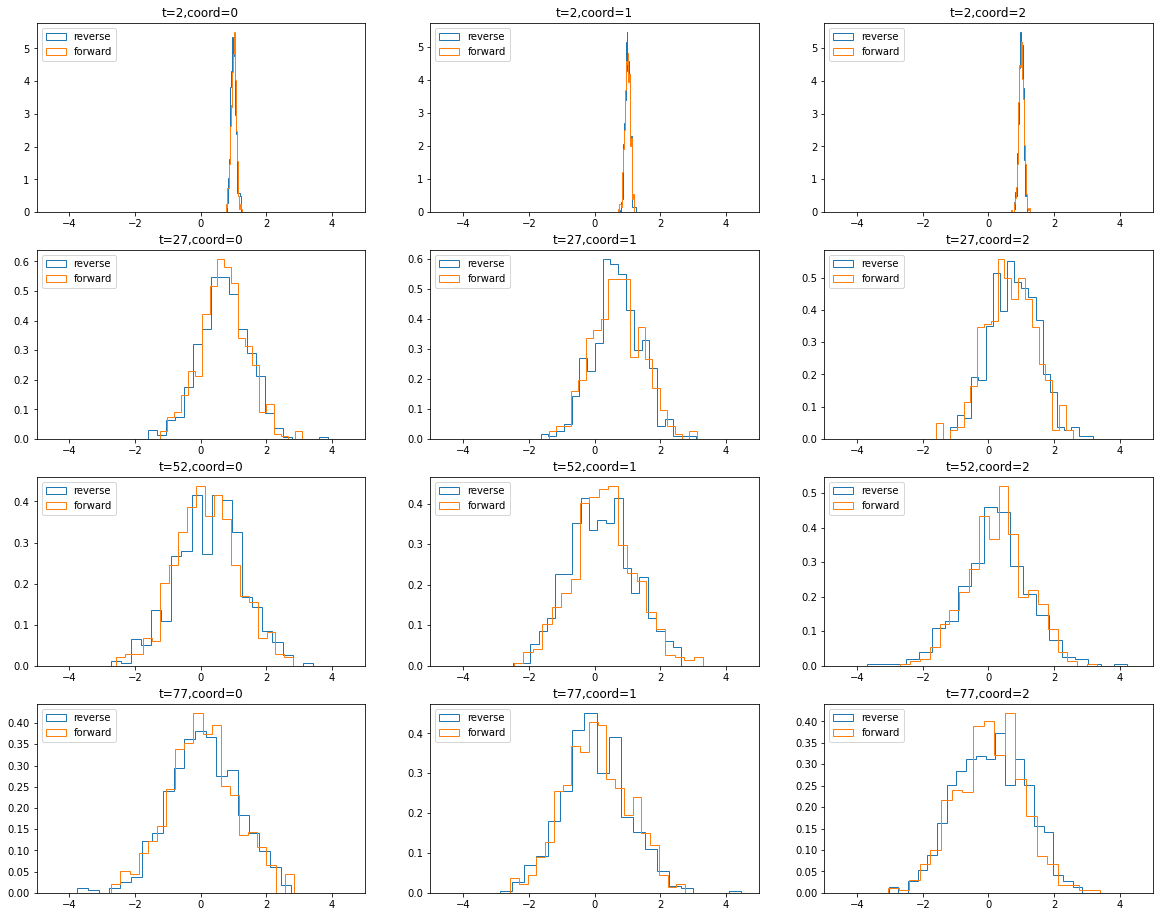

In [43]:
ts = np.arange(2, num_t, num_t//4)
f, axes = plt.subplots(len(ts), 3, figsize=[20, 4*len(ts)])
for i,t in enumerate(ts):
    for j in range(3):
        reverse_i = np.stack(reverse_samples[t])[:, 0, j]
        axes[i, j].hist(reverse_i, bins=20, density=True, label='reverse', histtype='step')

        forward_i = np.stack(marginal_samples[t])[:, 0, j]
        axes[i, j].hist(forward_i, bins=20, density=True, label='forward', histtype='step')

        axes[i, j].set_xlim(-5, 5)
        axes[i, j].set_title(f't={t},coord={j}')
        axes[i, j].legend(loc="upper left")


In [39]:
# Reverse diffusion
x_0 = np.ones((1, 3))
curr_step = r3_diff.sample_ref(n_samples=1)
all_steps = [curr_step]
for i, t in reversed(list(enumerate(forward_t))):
    score_t = r3_diff.score(
        curr_step,
        x_0,
        t)
    curr_step = r3_diff.reverse(
        x_t=curr_step,
        score_t=score_t,
        t=t,
        dt=dt,
        center=False
    )
    all_steps.append(
        copy.deepcopy(curr_step)
    )

In [50]:
all_steps[-3]

array([[0.95449574, 0.98254405, 1.02485172]])

# Rotations

In [23]:
# Forward diffusion
rot_0 = np.zeros((1, 3))
marginal_samples = {}
for i,t in enumerate(forward_t):
    marginal_samples[i] = []
    for _ in range(500):
        marginal_samples[i].append(
            so3_diff.forward_marginal(rot_0, t)[0])

In [6]:
# Reverse diffusion
reverse_samples = {}
for _ in range(500):
    curr_step = so3_diff.sample_ref(n_samples=1)
    for i, t in reversed(list(enumerate(forward_t))):
        if i not in reverse_samples:
            reverse_samples[i] = []
        score_t = so3_diff.score(curr_step, t)
        curr_step = so3_diff.reverse(
            rot_t=curr_step,
            score_t=score_t,
            t=t,
            dt=dt)
        reverse_samples[i].append(copy.deepcopy(curr_step))

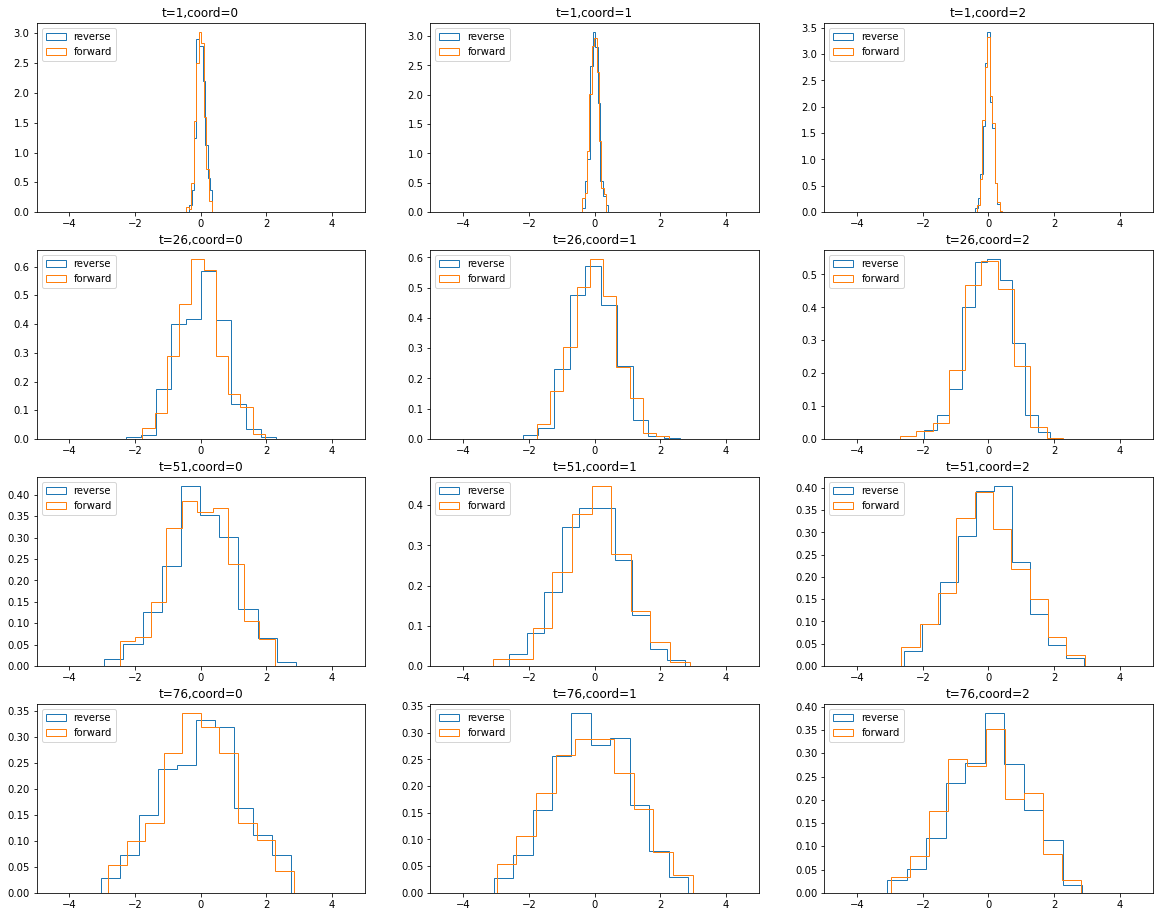

In [7]:
ts = np.arange(1, num_t, num_t//4)
f, axes = plt.subplots(len(ts), 3, figsize=[20, 4*len(ts)])
for i,t in enumerate(ts):
    for j in range(3):
        reverse_i = np.stack(reverse_samples[t])[:, 0, j]
        axes[i, j].hist(reverse_i, bins=10, density=True, label='reverse', histtype='step')

        forward_i = np.stack(marginal_samples[t])[:, 0, j]
        axes[i, j].hist(forward_i, bins=10, density=True, label='forward', histtype='step')

        axes[i, j].set_xlim(-5, 5)
        axes[i, j].set_title(f't={t},coord={j}')
        axes[i, j].legend(loc="upper left")


In [6]:
du.compose_rotvec

<function data.utils.compose_rotvec(r1, r2)>

In [16]:
num_samples = 1000

In [17]:
# Closed forward diffusion
rot_0 = np.zeros((1, 3))
marginal_samples = {}
for i,t in enumerate(forward_t):
    marginal_samples[i] = []
    for _ in range(num_samples):
        marginal_samples[i].append(
            so3_diff.forward_marginal(rot_0, t)[0])

In [ ]:
from scipy.spatial.transform import Rotation

def compose_rotvec(r1, r2):
    """Compose two rotation euler vectors."""
    def rotvec_to_matrix(rotvec):
        return Rotation.from_rotvec(rotvec).as_matrix()
    R1 = rotvec_to_matrix(r1)
    R2 = rotvec_to_matrix(r2)
    cR = np.einsum('...ij,...jk->...ik', R1, R2)
    return matrix_to_rotvec(cR)

def forward_diffuse(self, ts, n_samples=1):
    """Recursive forward SMLD sampling of x_t."""
    x_0 = torch.zeros((n_samples, 3))
    all_samples = []
    # Iterate through ts.
    for t in range(0, max(ts)+1):
        # Convert to continuous time and calculate sigma values.
        sigma_t = self.sigma(t / self.T)
        if t == 0:
            x_t_1 = x_0
            sigma_t_1 = 0
        else:
            x_t_1 = all_samples[t-1]
            sigma_t_1 = self.sigma((t-1) / self.T)
        z = torch.normal(0., 1., size=rot_0.shape)
        # Applies equation (8) in Song et al. with exponential mapping
        # onto SO(3) to simulate geodesic random walk.
        sampled_rot = torch.sqrt(sigma_t**2 - sigma_t_1**2) * z
        x_t = compose_rotvec(x_t_1, sampled_rot)
        all_samples.append(x_t)
    forward_traj = torch.stack(all_samples, axis=0)
    # Only take ts elements.
    return forward_traj[ts] 

In [ ]:
def forward_diffuse(self, ts, n_samples=1):
    """Recursive forward SMLD sampling of x_t."""
    x_0 = torch.zeros((n_samples, 3))
    all_samples = []
    # Iterate through ts.
    for t in range(0, max(ts)+1):
        # Convert to continuous time and calculate sigma values.
        sigma_t = self.sigma(t / self.T)
        if t == 0:
            x_t_1 = x_0
            sigma_t_1 = 0
        else:
            x_t_1 = all_samples[t-1]
            sigma_t_1 = self.sigma((t-1) / self.T)
        z = torch.normal(0., 1., size=rot_0.shape)
        # Applies equation (8) in Song et al.
        x_t = x_t_1 + torch.sqrt(sigma_t**2 - sigma_t_1**2) * z
        all_samples.append(x_t)
    forward_traj = torch.stack(all_samples, axis=0)
    # Only take ts elements.
    return forward_traj[ts] 

In [31]:
# Recursive Forward diffusion
forward_t_1 = np.roll(forward_t, 1)
rot_0 = np.zeros((num_samples, 3))
recursive_marginal_samples = {}
recursive_marginal_samples[0] = rot_0
for i,(t, t_1) in enumerate(zip(forward_t, forward_t_1)):
    sigma_t = so3_diff.sigma(t)
    if i == 0:
        rot_t_1 = rot_0
        sigma_t_1 = 0
    else:
        rot_t_1 = recursive_marginal_samples[i-1]
        sigma_t_1 = so3_diff.sigma(t_1)
    z = np.random.normal(size=rot_0.shape)
    sampled_rot = np.sqrt(sigma_t**2 - sigma_t_1**2) * z
    rot_t = du.compose_rotvec(rot_t_1, sampled_rot)
#     rot_t = rot_t_1 + sampled_rot
    recursive_marginal_samples[i] = rot_t


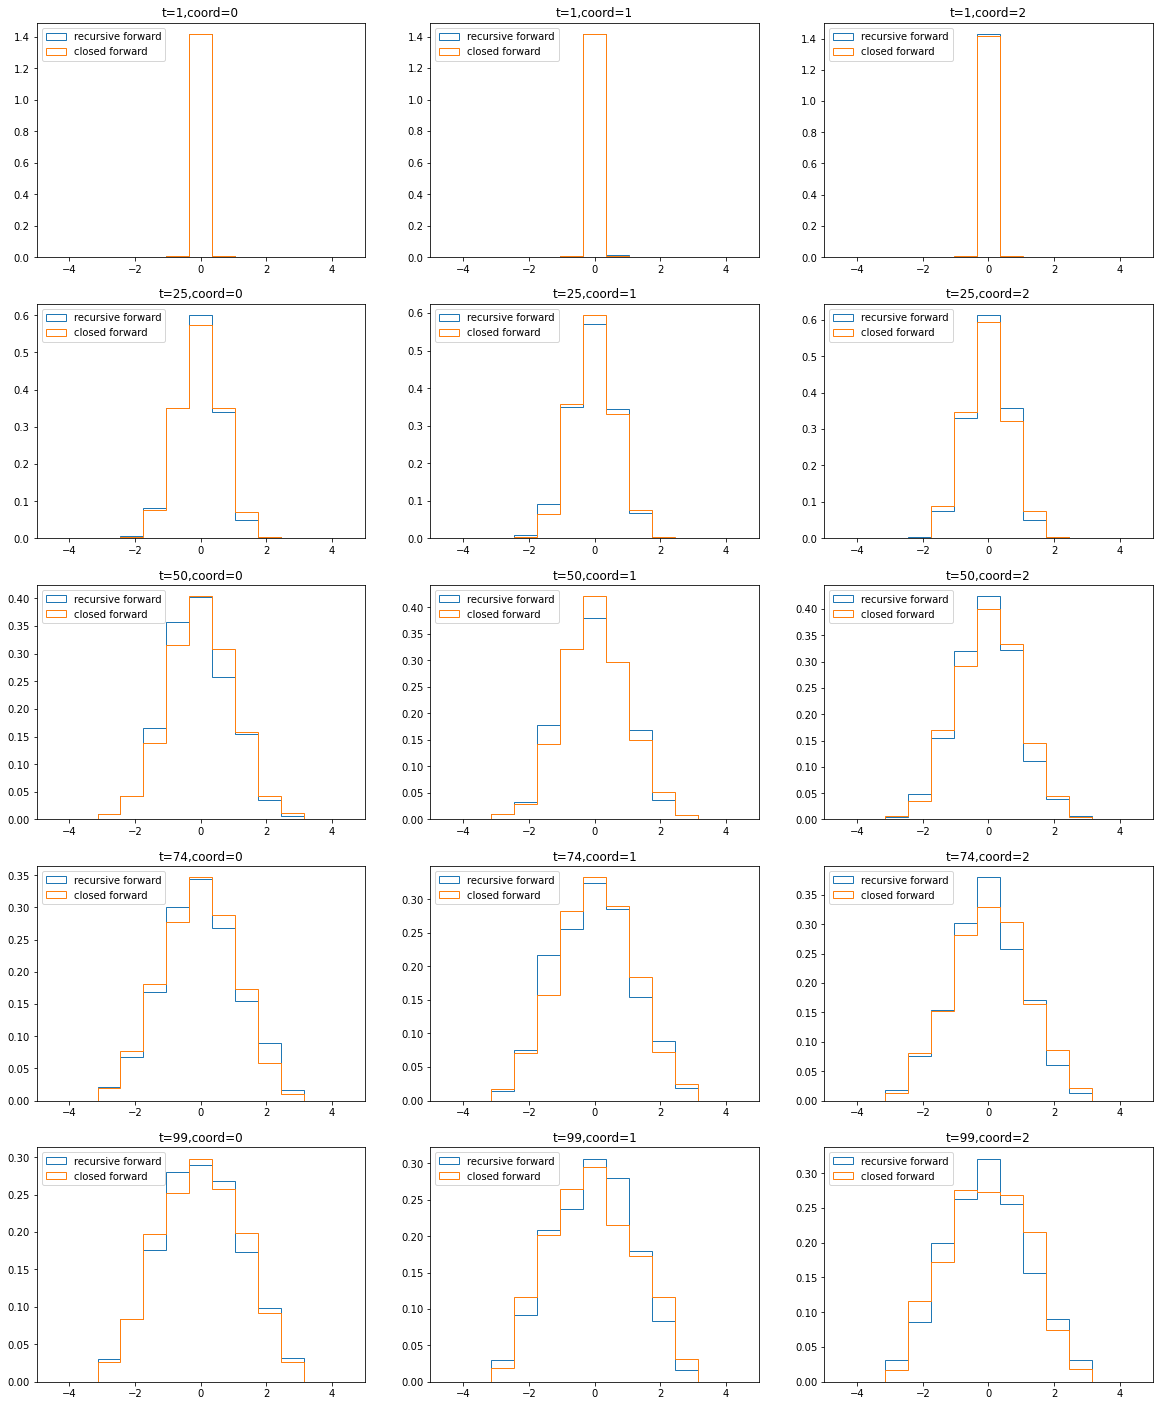

In [32]:
num_ts = 5
ts = np.linspace(1, num_t-1, num_ts).astype(int)
f, axes = plt.subplots(len(ts), 3, figsize=[20, num_ts*len(ts)])
bins = np.linspace(-np.pi, np.pi, 10)
for i,t in enumerate(ts):
    for j in range(3):
        reverse_i = recursive_marginal_samples[t][:, j]
        axes[i, j].hist(reverse_i, bins=bins, density=True, label='recursive forward', histtype='step')

        forward_i = np.stack(marginal_samples[t])[:, 0, j]
        axes[i, j].hist(forward_i, bins=bins, density=True, label='closed forward', histtype='step')

        axes[i, j].set_xlim(-5, 5)
        axes[i, j].set_title(f't={t},coord={j}')
        axes[i, j].legend(loc="upper left")


In [33]:
# Recursive Forward diffusion
forward_t_1 = np.roll(forward_t, 1)
rot_0 = np.zeros((num_samples, 3))
recursive_marginal_samples = {}
recursive_marginal_samples[0] = rot_0
for i,(t, t_1) in enumerate(zip(forward_t, forward_t_1)):
    sigma_t = so3_diff.sigma(t)
    if i == 0:
        rot_t_1 = rot_0
        sigma_t_1 = 0
    else:
        rot_t_1 = recursive_marginal_samples[i-1]
        sigma_t_1 = so3_diff.sigma(t_1)
    z = np.random.normal(size=rot_0.shape)
    sampled_rot = np.sqrt(sigma_t**2 - sigma_t_1**2) * z
#     rot_t = du.compose_rotvec(rot_t_1, sampled_rot)
    rot_t = rot_t_1 + sampled_rot
    recursive_marginal_samples[i] = rot_t


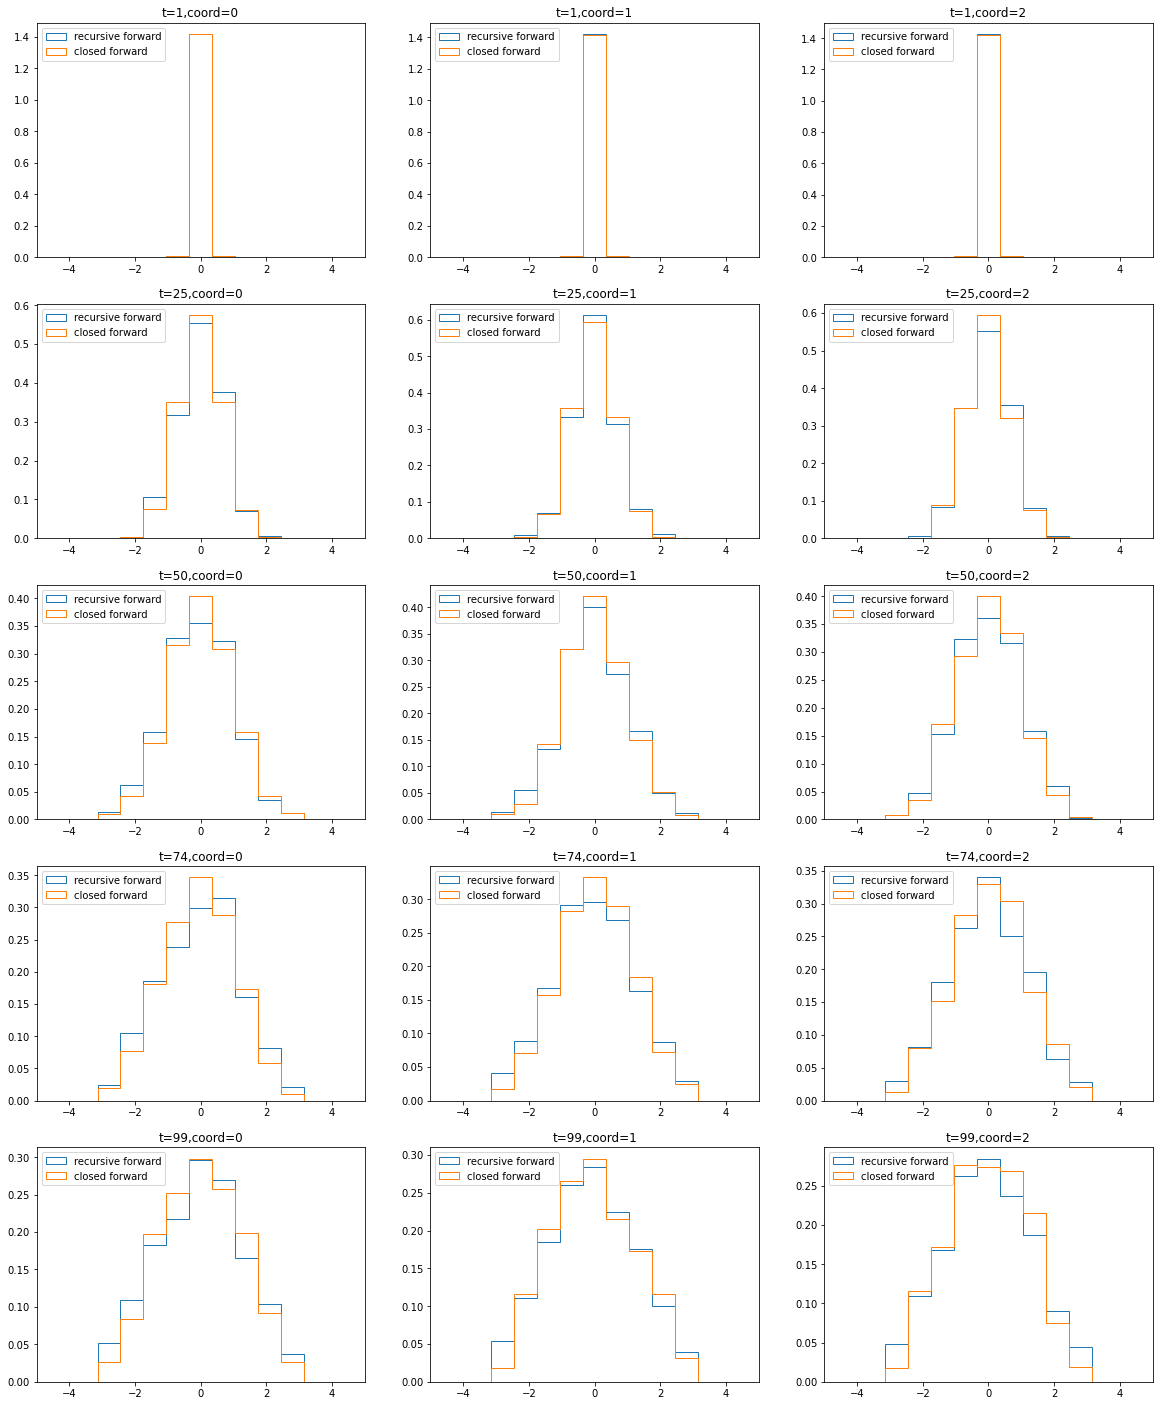

In [34]:
num_ts = 5
ts = np.linspace(1, num_t-1, num_ts).astype(int)
f, axes = plt.subplots(len(ts), 3, figsize=[20, num_ts*len(ts)])
bins = np.linspace(-np.pi, np.pi, 10)
for i,t in enumerate(ts):
    for j in range(3):
        reverse_i = recursive_marginal_samples[t][:, j]
        axes[i, j].hist(reverse_i, bins=bins, density=True, label='recursive forward', histtype='step')

        forward_i = np.stack(marginal_samples[t])[:, 0, j]
        axes[i, j].hist(forward_i, bins=bins, density=True, label='closed forward', histtype='step')

        axes[i, j].set_xlim(-5, 5)
        axes[i, j].set_title(f't={t},coord={j}')
        axes[i, j].legend(loc="upper left")


In [20]:
forward_t_1 = np.roll(forward_t, 1)
t, t_1 = zip(forward_t, forward_t_1)

In [21]:
forward_t_1[:5]

array([1.        , 0.001     , 0.01109091, 0.02118182, 0.03127273])

In [19]:
forward_t[:5]

array([0.001     , 0.01109091, 0.02118182, 0.03127273, 0.04136364])

In [ ]:
so3_diff.

# Rigid bodies

In [19]:
# Forward diffusion
num_res = 5
rigid_0 = ru.Rigid(
    rots=ru.Rotation(
        rot_mats=torch.Tensor(
            Rotation.from_rotvec(
                np.zeros((num_res, 3))
            ).as_matrix()
        )
    ),
    trans=torch.normal(0, 1, size=(num_res, 3))
)
    
marginal_samples = {}
for i,t in enumerate(forward_t):
    marginal_samples[i] = []
    for _ in range(500):
        marginal_samples[i].append(
            se3_diff.forward_marginal(rigid_0, t)[0].to_tensor_7())

In [23]:
# Reverse diffusion
reverse_samples = {}
for _ in range(500):
    curr_step = se3_diff.sample_ref(n_samples=num_res)
    for i, t in reversed(list(enumerate(forward_t))):
        if i not in reverse_samples:
            reverse_samples[i] = []
        trans_score, rot_score = se3_diff.score(rigid_0, curr_step, t)
        curr_step = se3_diff.reverse(
            rigid_t=curr_step,
            rot_score=rot_score,
            trans_score=trans_score,
            t=t,
            dt=dt,
            center=False
        )
        reverse_samples[i].append(copy.deepcopy(curr_step.to_tensor_7()))

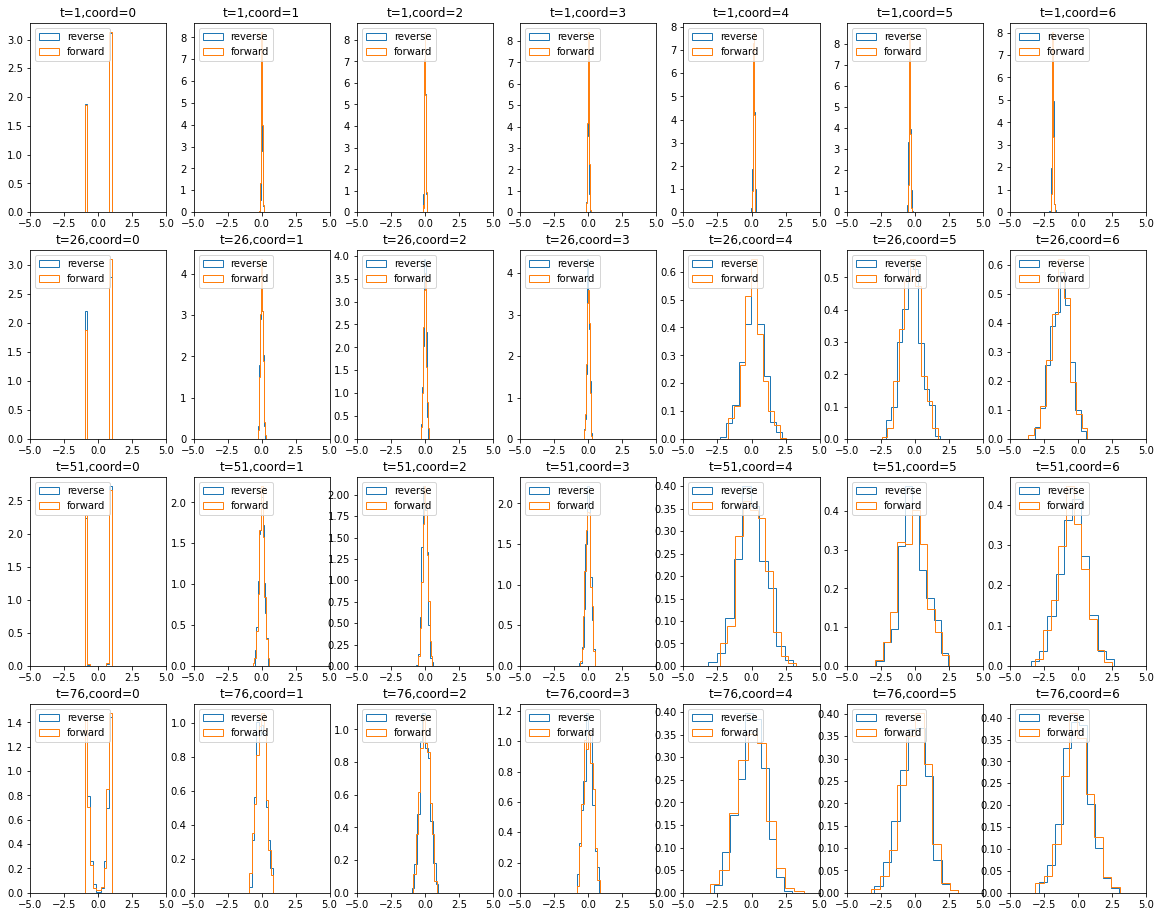

In [24]:
ts = np.arange(1, num_t, num_t//4)
num_coords = 7
f, axes = plt.subplots(len(ts), num_coords, figsize=[20, 4*len(ts)])
for i,t in enumerate(ts):
    for j in range(num_coords):
        reverse_i = np.stack(reverse_samples[t])[:, 0, j]
        axes[i, j].hist(reverse_i, bins=10, density=True, label='reverse', histtype='step')

        forward_i = np.stack(marginal_samples[t])[:, 0, j]
        axes[i, j].hist(forward_i, bins=10, density=True, label='forward', histtype='step')

        axes[i, j].set_xlim(-5, 5)
        axes[i, j].set_title(f't={t},coord={j}')
        axes[i, j].legend(loc="upper left")


# Score expected norms

Text(0.5, 1.0, 'R(3) diffuser expectation of score norm')

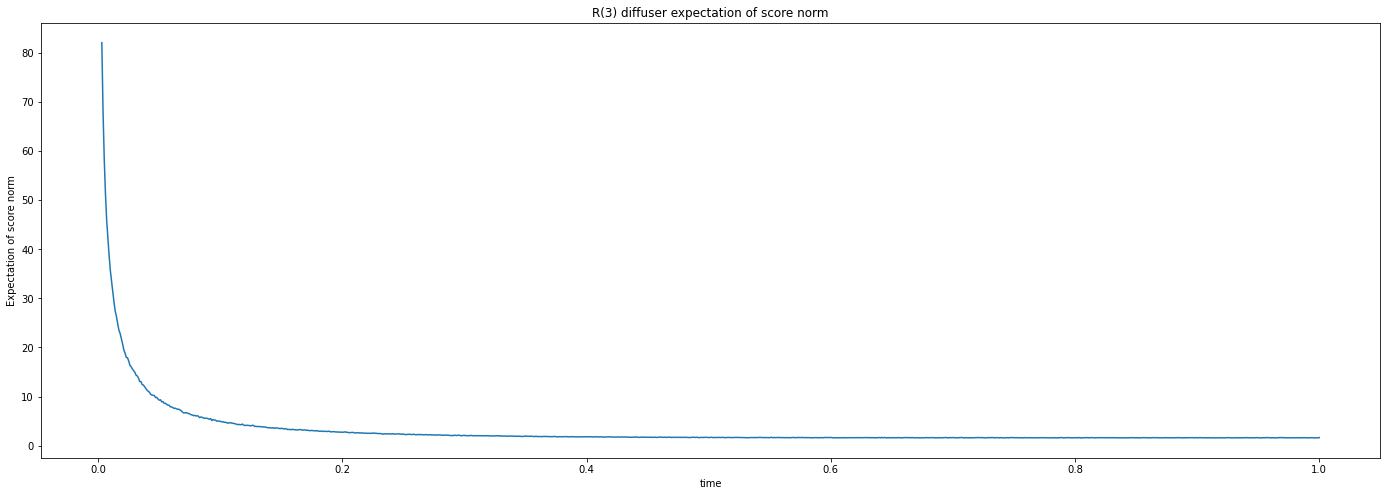

In [151]:
plt.figure(figsize=(24, 8))
plt.plot(
    r3_diff._discrete_t[3:],
    r3_diff._exp_score_norm[3:]
)
plt.xlabel('time')
plt.ylabel('Expectation of score norm')
plt.title('R(3) diffuser expectation of score norm')

In [ ]:
plt.figure(figsize=(24, 8))
plt.plot(
    r3_diff._discrete_t[3:],
    r3_diff._exp_score_norm[3:]
)
plt.xlabel('time')
plt.ylabel('Expectation of score norm')
plt.title('R(3) diffuser expectation of score norm')

# Real protein

In [61]:
se3_diff._diffuse_rot = False
se3_diff._diffuse_trans = True

In [62]:
gt_rigids_0 = next_item['rigids_0'][0][next_item['res_mask'][0].bool()]
rigid_0 = ru.Rigid.from_tensor_7(gt_rigids_0)

In [63]:
# rigid_0 = ru.Rigid.from_tensor_7(gt_rigids_0)

# marginal_samples = {}
# for i,t in enumerate(forward_t):
#     marginal_samples[i] = []
#     for _ in range(500):
#         marginal_samples[i].append(
#             se3_diff.forward_marginal(rigid_0, t)[0].to_tensor_7())

In [64]:
# Reverse diffusion
all_steps = []
# for _ in range(500):
curr_step = se3_diff.sample_ref(n_samples=gt_rigids_0.shape[0], impute=rigid_0)
for i, t in reversed(list(enumerate(forward_t))):
    trans_score, rot_score = se3_diff.score(rigid_0, curr_step, t)
    curr_step = se3_diff.reverse(
        rigid_t=curr_step,
        rot_score=rot_score,
        trans_score=trans_score,
        t=t,
        dt=dt,
        center=False
    )
    all_steps.append(copy.deepcopy(curr_step.to_tensor_7()))
#     reverse_samples[i].append(copy.deepcopy(curr_step.to_tensor_7()))

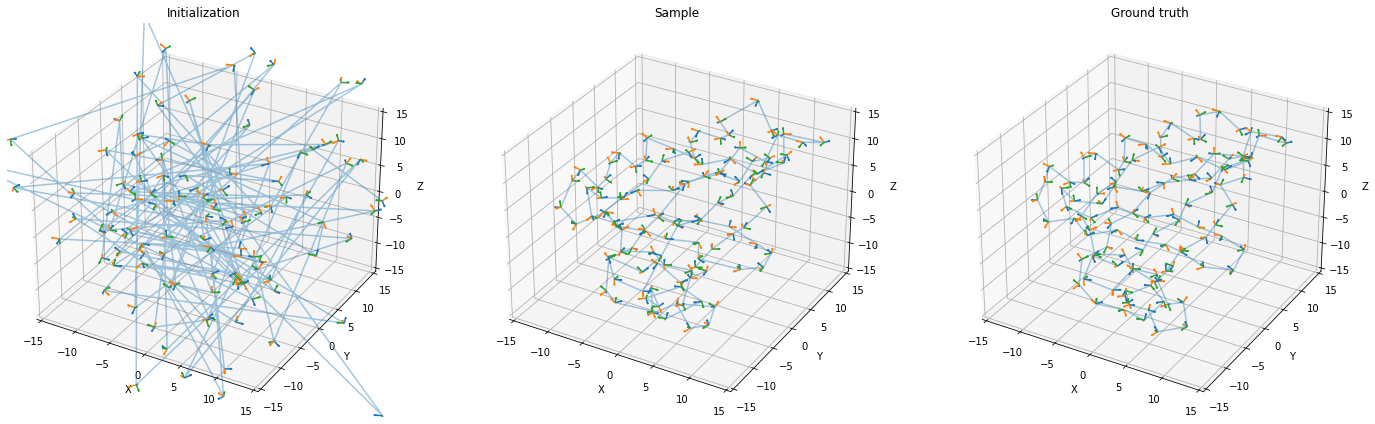

In [65]:
# Plot out SE(3)
initial_rigid = all_steps[0]
final_rigid = all_steps[-2]
res_mask = torch.ones(final_rigid.shape[0])
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))
scale_factor = conf.data.digs.scale_factor
ax_lim = 15.
# ax_lim = None
plotting.viz_frames(initial_rigid, res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(final_rigid, res_mask, axes[1], title='Sample', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(gt_rigids_0, res_mask, axes[2], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)